In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(chars, 1)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

In [5]:
block_size = 3

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(4)
random.shuffle(words)

n1 = int(0.8*len(words)) #80% of words
n2 = int(0.9*len(words)) #90% of words

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182359, 3]) torch.Size([182359])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22994, 3]) torch.Size([22994])


In [10]:
n_emb = 10 # dimensions of the embedding
n_hidden = 200 # hidden layer dimensions

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)


parameters = C, W1, b1, W2, b2,

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [11]:
lossi = []
def training_model(max_steps, batch_size):
    
    for i in range(max_steps):
    
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
    
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1 #hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function
    
        for p in parameters:
            p.grad = None
        loss.backward()
    
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += - lr * p.grad
    
        if i % 10000 == 0:
            print(f"{i:7d} / {max_steps: 7d} - {loss.item():.4f}")
    
        lossi.append(loss.log10().item())

training_model(200000, 32)

      0 /  200000 - 26.4902
  10000 /  200000 - 2.7476
  20000 /  200000 - 2.1814
  30000 /  200000 - 2.0946
  40000 /  200000 - 2.4267
  50000 /  200000 - 2.2138
  60000 /  200000 - 2.7386
  70000 /  200000 - 2.5777
  80000 /  200000 - 2.3359
  90000 /  200000 - 2.1164
 100000 /  200000 - 2.3496
 110000 /  200000 - 2.0124
 120000 /  200000 - 2.0058
 130000 /  200000 - 2.0519
 140000 /  200000 - 2.1438
 150000 /  200000 - 2.2542
 160000 /  200000 - 2.2221
 170000 /  200000 - 2.0790
 180000 /  200000 - 2.0429
 190000 /  200000 - 1.9406


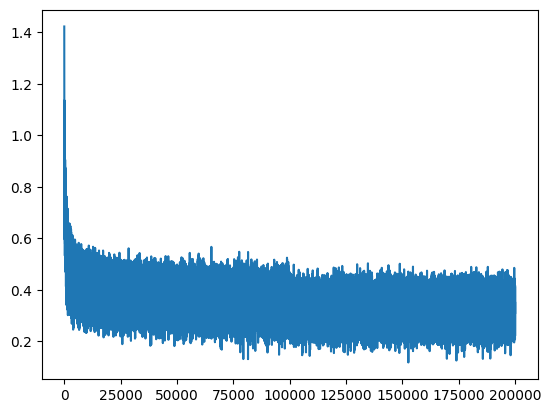

In [12]:
plt.plot(lossi)

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.12831711769104
val 2.1655433177948


In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimri.
reh.
cassanden.
jazhnen.
deliah.
jareei.
ner.
kipt.
maiir.
kaleigh.
ham.
join.
quintza.
lilea.
jadiq.
wakelo.
dearyn.
xik.


# Fixing Initialization

In [15]:
n_emb = 10 # dimensions of the embedding
n_hidden = 200 # hidden layer dimensions

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # 0.2 -> activation for tanh is 5/3 / fan_in ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


parameters = C, W1, b1, W2, b2,

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [16]:
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps: 7d} - {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0 /  200000 - 3.3364
  10000 /  200000 - 2.3251
  20000 /  200000 - 2.0175
  30000 /  200000 - 2.0461
  40000 /  200000 - 2.2193
  50000 /  200000 - 1.9438
  60000 /  200000 - 2.2804
  70000 /  200000 - 2.5303
  80000 /  200000 - 2.1070
  90000 /  200000 - 2.1020
 100000 /  200000 - 2.0999
 110000 /  200000 - 1.8593
 120000 /  200000 - 2.0125
 130000 /  200000 - 1.9712
 140000 /  200000 - 2.1215
 150000 /  200000 - 2.0599
 160000 /  200000 - 2.0389
 170000 /  200000 - 1.9218
 180000 /  200000 - 1.9608
 190000 /  200000 - 1.9159


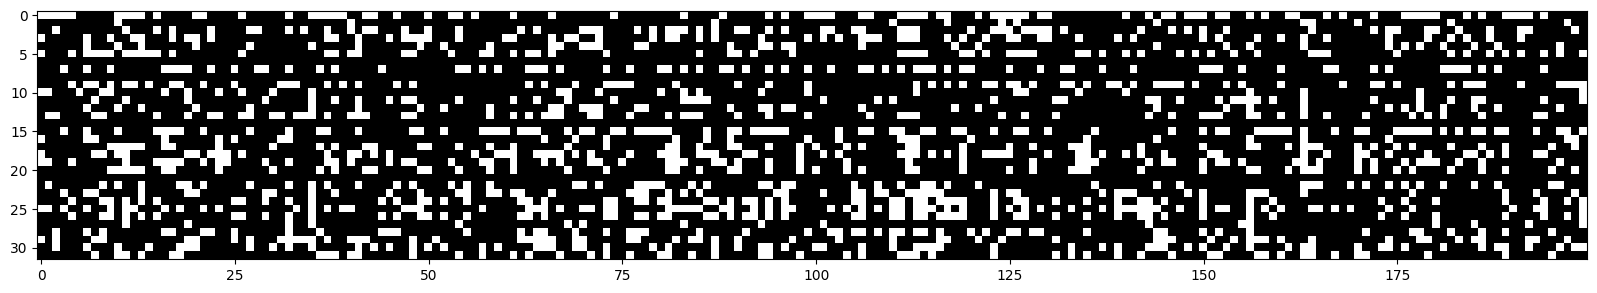

In [17]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

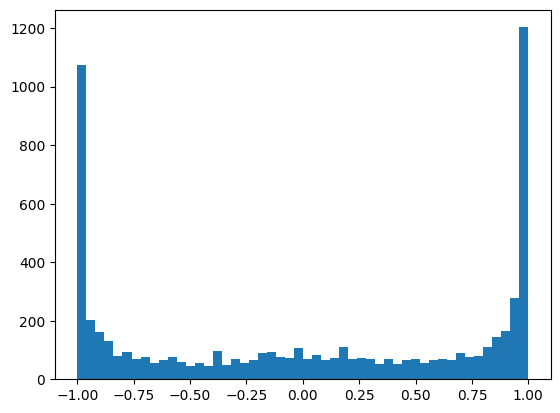

In [18]:
plt.hist(h.view(-1).tolist(), 50 );

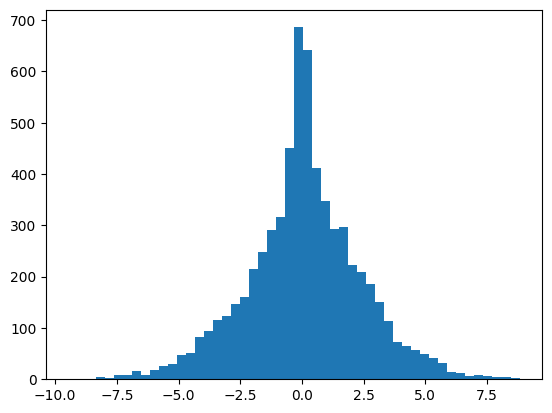

In [19]:
plt.hist(hpreact.view(-1).tolist(), 50 );

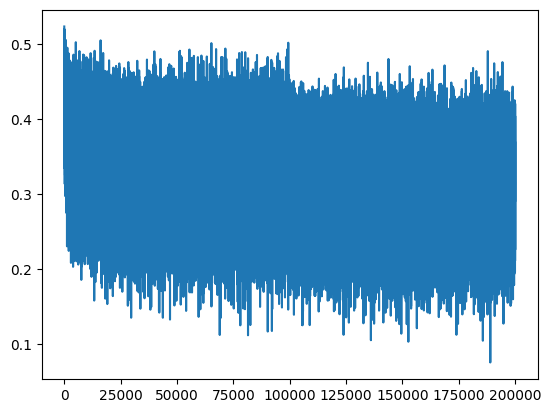

In [20]:
plt.plot(lossi)

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0384933948516846
val 2.10172963142395


[Resume here](https://youtu.be/P6sfmUTpUmc?t=1546)

tensor(0.0097) tensor(1.0047)
tensor(-0.0036) tensor(1.0233)


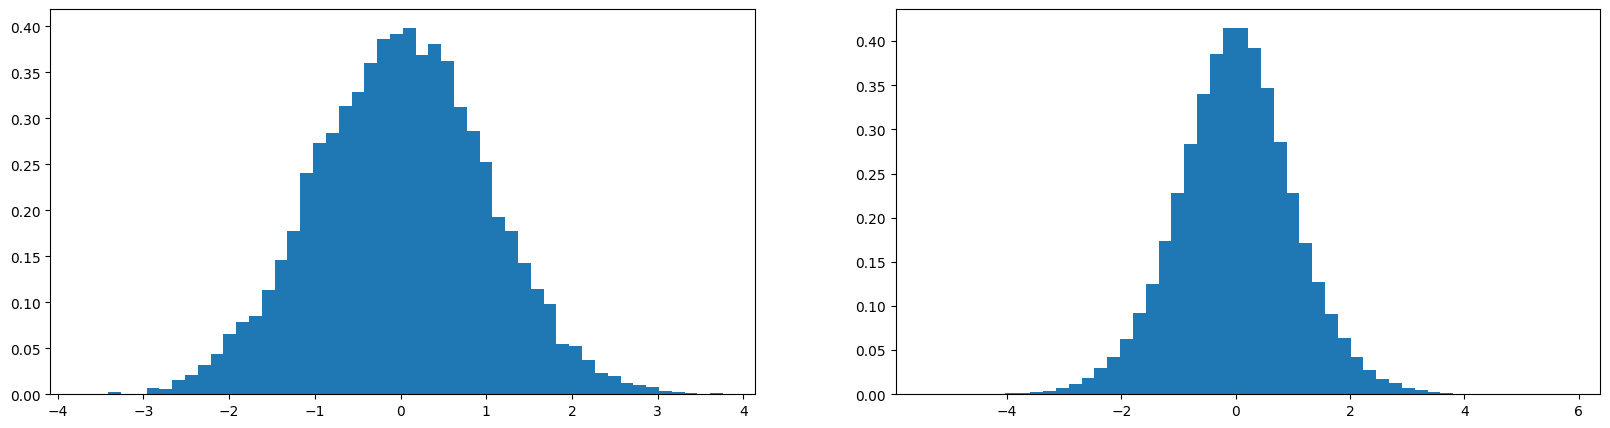

In [22]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5 # the weight can be multiplied with the square root of it's fan-in 

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


# Here the input is having a certain shape of input, but because
# of it's multiplication with the weight it's standard deviation is increasing which shows it's difference from the mean
# the weight shall be managed in a way to keep the standard deviation to 1 while maintaining it's shape.

# Changes to the weights
# 1. when multiplied with large(15) units it's std is increased
# 2. when squashing with smaller(0.5) units it's std is decreased

# Batch Normalization

![image.png](Batch-normalization.png)

> Every single neuron and it's firing rate will be exactly unifrom gausian on this batch

In [58]:
n_emb = 10 # dimensions of the embedding
n_hidden = 200 # hidden layer dimensions

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # 0.2 -> activation for tanh is 5/3 / fan_in ** 0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


# this allows the neurons be more flexible, at the initalization,
# where scale and shifting will add some gain and offset by some bias
# during backpropagation it can be changed for the purpose of better learning.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = C, W1, W2, b2, bngain, bnbias

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [105]:
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# +  b1 #hidden layer pre-activation batch normalization has it's own bias, so the bias with the weight is not impactful
    # hpreact_a = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact_a = bngain * (hpreact - bnmeani / bnstdi) + bnbias


    #bnmean_running is an alternative of explicitly calling the overall bnmean and std,
    # using the no_grad() wrapper in cell[50] here the mean and std are updated gently to reach the overall
    # bnmean and bnstd based on the training data, which is later used in the notebook to find the loss.
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact_a) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps: 7d} - {loss.item():.4f}")

    lossi.append(loss.log10().item())
    # break 

      0 /  200000 - 1.9119
  10000 /  200000 - 2.1159
  20000 /  200000 - 1.9029
  30000 /  200000 - 1.9083
  40000 /  200000 - 2.2320
  50000 /  200000 - 2.3089
  60000 /  200000 - 2.3397
  70000 /  200000 - 1.9734
  80000 /  200000 - 2.4987
  90000 /  200000 - 1.7992
 100000 /  200000 - 2.1779
 110000 /  200000 - 1.5942
 120000 /  200000 - 1.9675
 130000 /  200000 - 2.0518
 140000 /  200000 - 2.2384
 150000 /  200000 - 2.2152
 160000 /  200000 - 2.1936
 170000 /  200000 - 2.0767
 180000 /  200000 - 1.9881
 190000 /  200000 - 1.8907


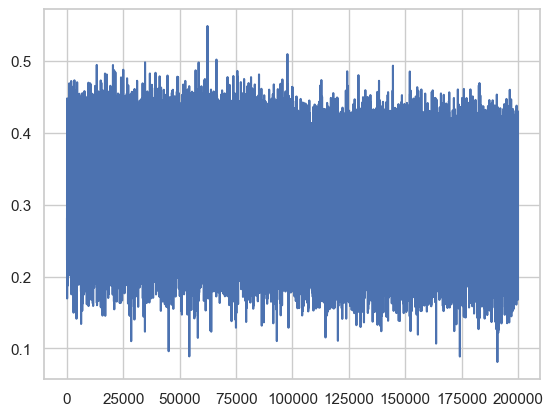

In [114]:
plt.plot(loss_log)

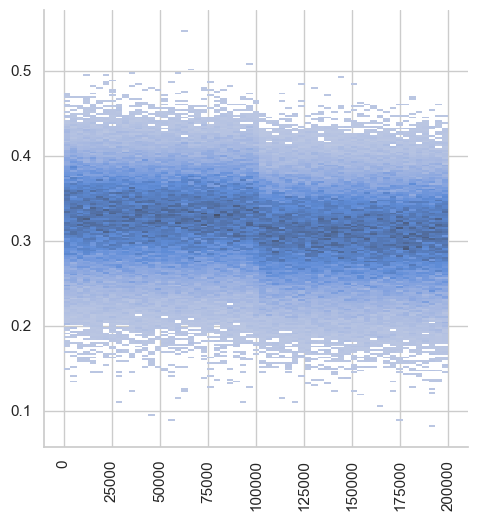

In [113]:
import seaborn as sns
import math

loss_log = [math.log10(loss) for loss in lossi]

sns.displot(x=range(len(loss_log)), y=loss_log)
plt.xticks(rotation=90)
plt.show()

# loss_log

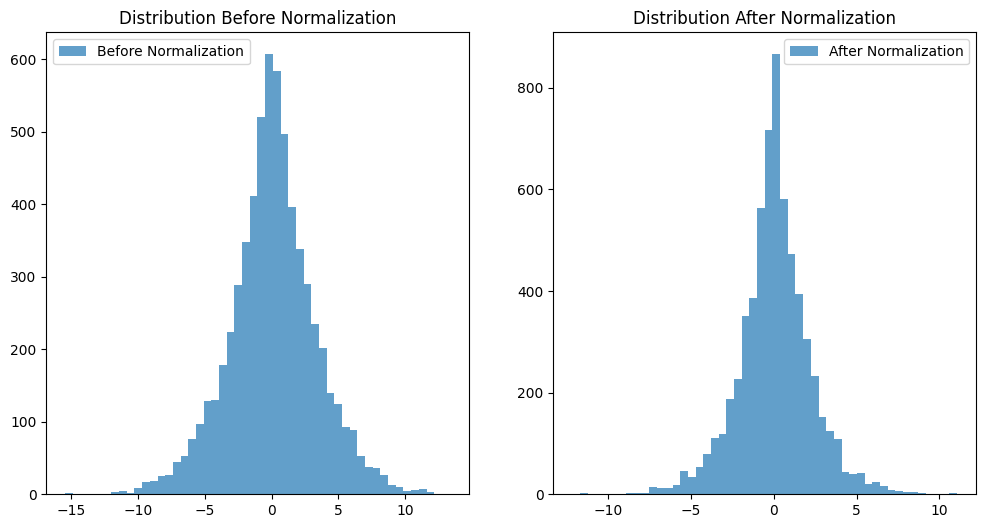

In [44]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hpreact.flatten().detach().numpy(), bins=50, alpha=0.7, label="Before Normalization")
plt.title("Distribution Before Normalization")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(hpreact_a.flatten().detach().numpy(), bins=50, alpha=0.7, label="After Normalization")
plt.title("Distribution After Normalization")
plt.legend()

plt.show()

In [45]:
print("Before normalization:")
print("Mean:", hpreact.mean().item())
print("Std Dev:", hpreact.std().item())

print("After normalization:")
print("Mean:", hpreact_a.mean().item())
print("Std Dev:", hpreact_a.std().item() )

Before normalization:
Mean: 0.09758303314447403
Std Dev: 3.2650651931762695
After normalization:
Mean: 0.035096246749162674
Std Dev: 2.2022650241851807


In [50]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [54]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact_a = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
    hpreact_a = bngain * (hpreact - bnmean_running / bnstd_running) + bnbias
    h = torch.tanh(hpreact_a) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0461463928222656
val 2.1054720878601074


[Resume here](https://youtu.be/P6sfmUTpUmc?t=3461)

In [115]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlaixatifn.
vif.
jord.
hentleenah.
sky.
rah.
trudge.
victoreyia.
hennia.
chriiv.
paith.
philmen.
cateriyah.
rozlei.
viduquorge.
phinaristin.
jenni.
sabell.
faiga.
giley.


In [117]:
class Linear:

    def __init__(self, fan_in: int, fan_out:int, bias: bool = True):
        """
        Initialization of the Linear Layer where the basic parameters are set
        """
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        """
        Returns the product of the parameters with the input, based on the input and the state of bias
        """
        self.out = x @ self.weight
        if self.bias:
            self.out += self.bias
        return self.out

    def parameters(self):
        """
        Returns the tensors which are parameters of the Layer considering the bias is used or not.
        """
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [118]:
class BatchNorm1d:

    def __init__(self, dim:int, eps:int=1e-5, momentum:int=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with back props
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers -> trained with momentum update
        self.running_mean =torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):

        ##### forward pass #####
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        # above we are using the torch.sqrt because we are using the variance instead of std as used earlier
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [119]:
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [122]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


[Resume Here](https://youtu.be/P6sfmUTpUmc?t=5146)